# Set Data Variables

In [1]:
import pandas as pd
import os
print(os.getcwd())

IMAGE_DIR = "/mnt/sarl_commons06/Wernke_projects/GeoPACHA/Imagery_Machine_Learning/Analysis_Images"
VECTOR_DIR = "/mnt/sarl_commons06/Wernke_projects/GeoPACHA/Imagery_Machine_Learning/ChipClassification/"
#Import a scenes csv as a pandas dataframe. This is the labeled scenes from Region01
scene_path='/mnt/sarl_commons06/Wernke_projects/GeoPACHA/Imagery_Machine_Learning/ChipClassification/ml_data_2024_10_23/scenes_train_tiny.csv'
train_df = pd.read_csv(scene_path)

# val_df = pd.read_csv('/workspace/data/automated_data_prep/ml_data_2024_08_23/scenes_validation.csv')


/home/VANDERBILT/zimmejr1/Documents/Co-DETR_RS


# Define Data Pipelne

In [2]:
from mmdet.datasets.rastervision_dataset import RasterVisionDataset
from rastervision.core.data import ClassConfig
class_config = ClassConfig(
names=['nothing', 'object'],
colors=['lightgray', 'lightblue'],
null_class='nothing')
pipeline = [
    dict(type='Resize', img_scale=(224, 224), keep_ratio=True),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='Pad', size_divisor=32),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_bboxes', 'gt_labels']),]

/home/VANDERBILT/zimmejr1/anaconda3/envs/codetr/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/VANDERBILT/zimmejr1/anaconda3/envs/codetr/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
2024-11-21 13:09:17:rastervision.pipeline.rv_config: WARNING - Root temporary directory cannot be used: /opt/data/tmp. Using root: /tmp/tmph7fazx7k


# Create Dataset

In [3]:
datasets = [RasterVisionDataset(image_dir=IMAGE_DIR,vector_dir=VECTOR_DIR,scene_csv_path=scene_path,class_config=class_config,pipeline=pipeline)]

Reading /mnt/sarl_commons06/Wernke_projects/GeoPACHA/Imagery_Machine_Learning/ChipClassification/ml_data_2024_10_23/scenes_train_tiny.csv
Building Scenes
Building Datasets
LOADING ANNOTATIONS


# Define Plotting Function

In [4]:
import matplotlib.pyplot as plt
import torch
import torchvision

class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        output_tensor = []
        for t, m, s in zip(tensor, self.mean, self.std):
            output_tensor.append(t.mul(s).add(m))
            # t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return torch.stack(output_tensor, dim=0)

unnorm = UnNormalize(mean=(0.15, 0.15, 0.15), std=(0.6, 0.6, 0.6))

def plot_results(img, labels, boxes, mask=None):
    print(img.shape)
    img = img[[4,2,1],:,:]
    h, w = img.shape[1:]
    if mask != None:
        # width
        if torch.where(mask[0])[0].shape[0] > 0:
            mask_w = torch.where(mask[0])[0][0]
            w = min(w, mask_w)
        if torch.where(mask[:, 0])[0].shape[0]:
            mask_h = torch.where(mask[:, 0])[0][0]
            h = min(h, mask_h)
    plt.figure(figsize=(16,10))
    unimage = unnorm(img)
    #image = (unimage*256).to(torch.uint8)
    image = unimage
    pil_img = torchvision.transforms.functional.to_pil_image(image)
    plt.imshow(pil_img)
    
    ax = plt.gca()
    colors = COLORS * 100
    for label, (xmin, ymin, xmax, ymax), c in zip(labels, boxes.tolist(), colors):
        print("rectangle coords: ", (xmin, ymin, xmax, ymax))
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{CLASSES[label]}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

torch.Size([8, 224, 224])
rectangle coords:  (150.85714721679688, 0.0, 224.0, 28.952381134033203)
rectangle coords:  (138.66665649414062, 16.761903762817383, 187.42857360839844, 60.95238494873047)
rectangle coords:  (100.5714340209961, 0.0, 224.0, 175.23809814453125)


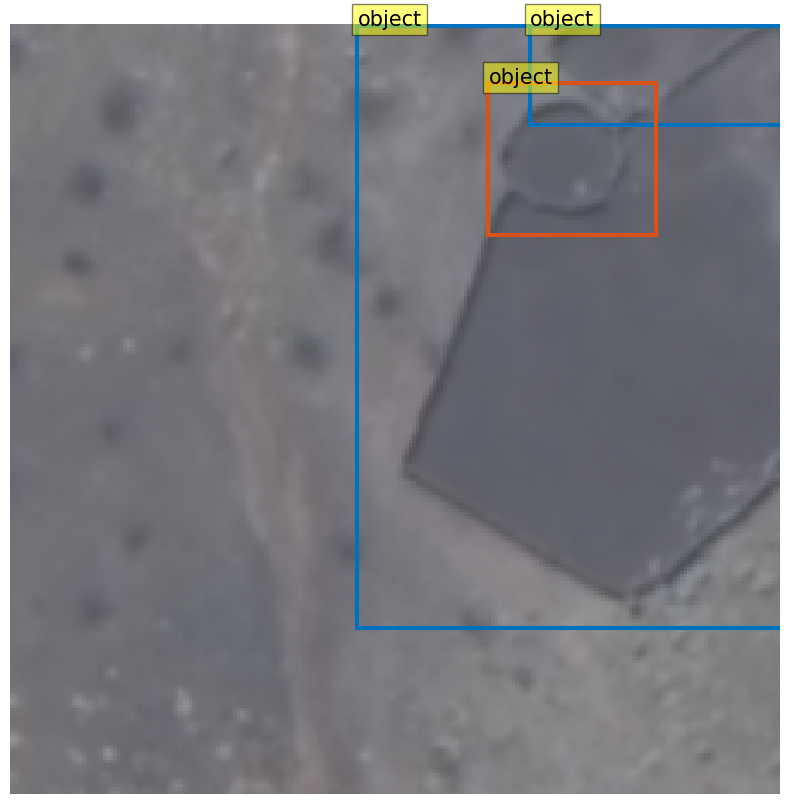

DataContainer(tensor([[150.8571,   0.0000, 224.0000,  28.9524],
        [138.6667,  16.7619, 187.4286,  60.9524],
        [100.5714,   0.0000, 224.0000, 175.2381]]))


In [15]:
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], ]
CLASSES = ['no_object','object']
count=0
for sample in datasets[0]:
    if len(sample["gt_labels"].data)>2:
        count+=1
        if count>5:
            plot_results(sample["img"].data, sample["gt_labels"].data, sample["gt_bboxes"].data)
            print(sample["gt_bboxes"])
            break

In [ ]:
datasets[0][0]

In [6]:
from argparse import Namespace
import os
args = Namespace(config='projects/configs/co_dino_vit/co_dino_DINOv2_experiments.py', work_dir='my_exp1', resume_from=None,
                  auto_resume=False, no_validate=False, gpus=None, gpu_ids=None, gpu_id=0, seed=42, diff_seed=False, deterministic=False,
                    options=None, cfg_options=None, launcher='pytorch', local_rank=0, auto_scale_lr=False)

os.environ['LOCAL_RANK'] = '0'
os.environ['RANK'] = '0'
os.environ['GROUP_RANK'] = '0'
os.environ['ROLE_RANK'] = '0'
os.environ['ROLE_NAME'] = 'default'
os.environ['LOCAL_WORLD_SIZE'] = '1'
os.environ['WORLD_SIZE'] = '1'
os.environ['GROUP_WORLD_SIZE'] = '1'
os.environ['ROLE_WORLD_SIZE'] = '1'
os.environ['MASTER_ADDR'] = '127.0.0.1'
os.environ['MASTER_PORT'] = '29500'


In [7]:
import argparse
import copy
import os
import os.path as osp
import time
import warnings

import mmcv
import torch
import torch.distributed as dist
from mmcv import Config, DictAction
from mmcv.runner import get_dist_info, init_dist
from mmcv.utils import get_git_hash

from mmdet import __version__
from mmdet.apis import init_random_seed, set_random_seed, train_detector
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.utils import (collect_env, get_device, get_root_logger,
                         replace_cfg_vals, setup_multi_processes,
                         update_data_root)
from projects import *

In [8]:
cfg = Config.fromfile(args.config)
cfg = replace_cfg_vals(cfg)
update_data_root(cfg)
if args.cfg_options is not None:
    cfg.merge_from_dict(args.cfg_options)

if args.auto_scale_lr:
    if 'auto_scale_lr' in cfg and \
            'enable' in cfg.auto_scale_lr and \
            'base_batch_size' in cfg.auto_scale_lr:
        cfg.auto_scale_lr.enable = True
    else:
        warnings.warn('Can not find "auto_scale_lr" or '
                        '"auto_scale_lr.enable" or '
                        '"auto_scale_lr.base_batch_size" in your'
                        ' configuration file. Please update all the '
                        'configuration files to mmdet >= 2.24.1.')

# set multi-process settings
setup_multi_processes(cfg)

In [ ]:
if cfg.get('cudnn_benchmark', False):
    torch.backends.cudnn.benchmark = True

# work_dir is determined in this priority: CLI > segment in file > filename
if args.work_dir is not None:
    # update configs according to CLI args if args.work_dir is not None
    cfg.work_dir = args.work_dir
elif cfg.get('work_dir', None) is None:
    # use config filename as default work_dir if cfg.work_dir is None
    cfg.work_dir = osp.join('./work_dirs',
                            osp.splitext(osp.basename(args.config))[0])

if args.resume_from is not None:
    cfg.resume_from = args.resume_from
cfg.auto_resume = args.auto_resume
if args.gpus is not None:
    cfg.gpu_ids = range(1)
    warnings.warn('`--gpus` is deprecated because we only support '
                    'single GPU mode in non-distributed training. '
                    'Use `gpus=1` now.')
if args.gpu_ids is not None:
    cfg.gpu_ids = args.gpu_ids[0:1]
    warnings.warn('`--gpu-ids` is deprecated, please use `--gpu-id`. '
                    'Because we only support single GPU mode in '
                    'non-distributed training. Use the first GPU '
                    'in `gpu_ids` now.')
if args.gpus is None and args.gpu_ids is None:
    cfg.gpu_ids = [args.gpu_id]

# init distributed env first, since logger depends on the dist info.
if args.launcher == 'none':
    distributed = False
else:
    distributed = True
    init_dist(args.launcher, **cfg.dist_params)
    # re-set gpu_ids with distributed training mode
    _, world_size = get_dist_info()
    cfg.gpu_ids = range(world_size)

# create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
# dump config
cfg.dump(osp.join(cfg.work_dir, osp.basename(args.config)))
# init the logger before other steps
timestamp = time.strftime('%Y%m%d_%H%M%S', time.localtime())
log_file = osp.join(cfg.work_dir, f'{timestamp}.log')
logger = get_root_logger(log_file=log_file, log_level=cfg.log_level)

# init the meta dict to record some important information such as
# environment info and seed, which will be logged
meta = dict()
# log env info
env_info_dict = collect_env()
env_info = '\n'.join([(f'{k}: {v}') for k, v in env_info_dict.items()])
dash_line = '-' * 60 + '\n'
logger.info('Environment info:\n' + dash_line + env_info + '\n' +
            dash_line)
meta['env_info'] = env_info
meta['config'] = cfg.pretty_text
# log some basic info
logger.info(f'Distributed training: {distributed}')
logger.info(f'Config:\n{cfg.pretty_text}')

cfg.device = get_device()
# set random seeds
seed = init_random_seed(args.seed, device=cfg.device)
seed = seed + dist.get_rank() if args.diff_seed else seed
logger.info(f'Set random seed to {seed}, '
            f'deterministic: {args.deterministic}')
set_random_seed(seed, deterministic=args.deterministic)
cfg.seed = seed
meta['seed'] = seed
meta['exp_name'] = osp.basename(args.config)

In [ ]:
model = build_detector(
    cfg.model,
    train_cfg=cfg.get('train_cfg'),
    test_cfg=cfg.get('test_cfg'))
model.init_weights()

In [11]:
from mmdet.utils import (build_ddp, build_dp, compat_cfg,
                         find_latest_checkpoint, get_root_logger)

from mmdet.datasets import (build_dataloader, build_dataset,
                            replace_ImageToTensor)

dataset = datasets
cfg = compat_cfg(cfg)
logger = get_root_logger(log_level=cfg.log_level)

# prepare data loaders
dataset = dataset if isinstance(dataset, (list, tuple)) else [dataset]

runner_type = 'EpochBasedRunner' if 'runner' not in cfg else cfg.runner[
    'type']

train_dataloader_default_args = dict(
    samples_per_gpu=1,
    workers_per_gpu=1,
    # `num_gpus` will be ignored if distributed
    num_gpus=len(cfg.gpu_ids),
    dist=distributed,
    seed=49,
    runner_type=runner_type,
    persistent_workers=False)

train_loader_cfg = {
    **train_dataloader_default_args,
    **cfg.data.get('train_dataloader', {})
}

data_loaders = [build_dataloader(ds, **train_loader_cfg) for ds in dataset]

In [ ]:
for samples in data_loaders[0]:
    break
samples

In [13]:
# put model on gpus
if distributed:
    find_unused_parameters = cfg.get('find_unused_parameters', False)
    # Sets the `find_unused_parameters` parameter in
    # torch.nn.parallel.DistributedDataParallel
    model = build_ddp(
        model,
        cfg.device,
        device_ids=[int(os.environ['LOCAL_RANK'])],
        broadcast_buffers=False,
        find_unused_parameters=find_unused_parameters)
else:
    model = build_dp(model, cfg.device, device_ids=cfg.gpu_ids)

In [ ]:
model(**samples)

In [18]:
if len(cfg.workflow) == 2:
    assert 'val' in [mode for (mode, _) in cfg.workflow]
    val_dataset = copy.deepcopy(cfg.data.val)
    val_dataset.pipeline = cfg.data.train.get(
        'pipeline', cfg.data.train.dataset.get('pipeline'))
    datasets.append(build_dataset(val_dataset))
if cfg.checkpoint_config is not None:
    # save mmdet version, config file content and class names in
    # checkpoints as meta data
    cfg.checkpoint_config.meta = dict(
        mmdet_version=__version__ + get_git_hash()[:7],
        CLASSES=datasets[0].CLASSES)
# add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

In [ ]:
train_detector(
    model,
    datasets,
    cfg,
    distributed=distributed,
    validate=(not args.no_validate),
    timestamp=timestamp,
    meta=meta)

In [21]:
from mmdet.models.backbones.dinov2 import vit_large

dinov2_model=vit_large(patch_size=14)



In [ ]:
pretrained_weights = "/mnt/sarl_commons06/Wernke_projects/zimmejr1/geopacha/output/unsupervised/from_container/NEH_new/6gpus/eval/training_324999/teacher_checkpoint.pth"
os.path.exists(pretrained_weights)

In [ ]:
junlin_model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')
teacher_checkpoint = pretrained_weights # path to .pth
pretrained_dict = torch.load(teacher_checkpoint)
checkpoint_key = 'teacher'
new_state_dict = {}
for k, v in pretrained_dict[checkpoint_key].items():
    if 'dino_head' in k:
        print(f'{k} not used')    
    elif 'ibot_head' in k:
        print(f'{k} not used')
    else:
        new_key = k.replace('backbone.', '')
        new_state_dict[new_key] = v
#change shape of pos_embed, shape depending on vits or vitg, or  vitl
pos_embed = nn.Parameter(torch.zeros(1, 257, 1024))
junlin_model.pos_embed = pos_embed# change shape of patch embed (it was not all correct)
# patch_embed_weight = nn.Parameter(torch.zeros(1024, 8, 14, 14))
# model.patch_embed.proj.weight = patch_embed_weight########################################################################
new_patch_embed = junlin_model.patch_embed
new_patch_embed.proj = nn.Conv2d(
    in_channels=8,  # Updated for 8 input bands
    out_channels=new_patch_embed.proj.out_channels,
    kernel_size=new_patch_embed.proj.kernel_size,
    stride=new_patch_embed.proj.stride,
    padding=new_patch_embed.proj.padding,
    # bias=new_patch_embed.proj.bias,
)
# Replace the old PatchEmbed with the updated one
junlin_model.patch_embed = new_patch_embed# load state dict
junlin_model.load_state_dict(new_state_dict, strict=True)

In [34]:
output = junlin_model.forward_features(samples['img'].data[0])

In [ ]:
samples['img'].data[0].shape

In [15]:
output = dinov2_model.forward_features(samples['img'].data[0])

In [ ]:
output.keys()

In [ ]:
output['x_norm_patchtokens'].reshape(1,16,16,1024).shape

In [ ]:
model(**samples)

In [ ]:
output['x_norm_patchtokens'].reshape(1,14,14,1024).shape

In [ ]:
dinov2_vitl14